In [1]:
import random

import torch
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import MSTDPET, PostPre, NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

from libs.learning import PostPreInh, MSTDPET_SEASONAL, MSTDP_SEASONAL, RSTDP_SEASONAL, AbstractSeasonalLearning
from libs.second_appr_simp_t import CorticalColumn, LayerConnection, ComplexStructure, AbstractRewardSystem, LAYER_23, LAYER_4
from libs.connections import ConnectionWithConvergence, RandomConnection

In [2]:
seed = random.randint(0,9999999)
print(seed)

495460


In [3]:
# seed = 1400
# random.seed(seed)
# np.random.seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.manual_seed(seed)

In [4]:
input_size = 100
each_session = 30
session_number = 1000
layer23_involve_from = 500
gap_time = 20

time = session_number * each_session
spike_train = torch.zeros(time, input_size).bool()
timestep_class = torch.zeros(time).bool()

session_class = torch.rand(session_number) < 0.5
# session_class = torch.tensor(([True, False] * int((session_number + 1) / 2))[:session_number])

active_fire_rate = 0.2
pattern_size = int(input_size/2)

for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, :int(input_size/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, int(input_size/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls

In [5]:
spike_train.T[:, 100:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

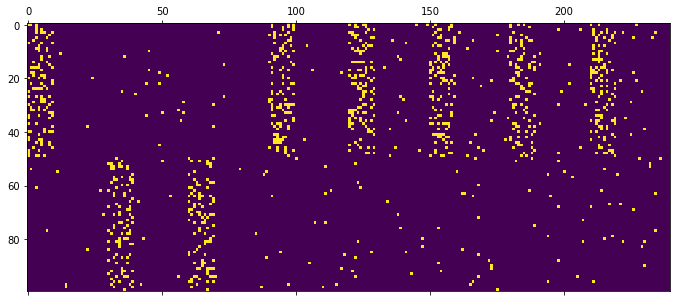

In [6]:
import matplotlib.pyplot as plt

plt.matshow(spike_train.T[:, :8 * each_session])

In [7]:
connection_args = { # Between Layer
    'wmin': 0.,
    'wmax': 2.7,
    'nu': 0.05, # [-, +]
    'probability': 0.3,
    'weight_decay': 0.00000,
    'update_rule': MSTDP_SEASONAL,
    
    'tc_plus': 10,
    'tc_minus': 10, 
    'tc_e_trace': 10,
}
layer_args_l23 = {
    'exc_size': 100,
    'inh_con_args': { # Inside Layer
        'wmin': -3.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 1.0,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 10,
        'traces': True,
        'tc_decay': 10,
        'refrac': 0,
    }
}
layer_args_l4 = {
    'exc_size': 50,
    'inh_con_args': { # Inside Layer
        'wmin': -0.6,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.50,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 10,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
        'rest':-57
    }
}
connection_type = RandomConnection

In [8]:
input_pop_c1 = Input(input_size, traces=True, tc_trace=10)
c1 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, connection_type, name="c1", monitor=LAYER_23|LAYER_4)
input_to_c1_connection = LayerConnection(("input_c1", input_pop_c1), c1, connection_type, {
    'wmin': 0.,
    'wmax': 2.0,
    'nu': 0.04,
#     'update_rule': MSTDPET_SEASONAL,
    'update_rule': PostPre,
    'probability': 0.50
})

In [9]:
c1_with_input = ComplexStructure()
c1_with_input.add_pop('input_c1', input_pop_c1)
c1_with_input.add_submodule(c1)
c1_with_input.add_submodule(input_to_c1_connection)
c1_with_input.add_outpops(c1.get_output_pops())

In [10]:
network = Network(dt=1.0)
c1_with_input.add_to_network(network)

bl_monitors = []
bl_monitors_name = []
for a, b, con in c1.l4_l23.connections + input_to_c1_connection.connections:
    tmp = Monitor(obj=con, state_vars=['converge'])
    network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
    bl_monitors.append(tmp)
    bl_monitors_name.append((a, b))
    

In [11]:
# Disable layer 2,3
c1.l23.disable_learning()
c1.l4_l23.disable_learning()

In [12]:
for x in c1.l4_l23.connections:
    print(x[2].update_rule)

In [13]:
from tqdm import trange

rewards = []
changes = []
activities = []
# inputs = {'input_c1' : spike_train}
for part in trange(session_number, unit="parts"):
# for part in trange(1, unit="parts"):

    if part == layer23_involve_from:
        c1.l4.disable_learning()
        input_to_c1_connection.disable_learning()
        
        c1.l23.enable_learning()
        c1.l4_l23.enable_learning()
        
        
    inp = {'input_c1': spike_train[part*each_session:part*each_session+each_session, :]}
    network.run(inputs=inp, time=each_session)
    
    avg_sessions = 10
    in_use_sessions = min(part + 1, avg_sessions)
    exc1_avg = c1.l23.monitors[0][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    exc2_avg = c1.l23.monitors[1][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    
    exc1_act = c1.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()# - exc1_avg
    exc2_act = c1.l23.monitors[1][1].get('s')[-each_session:,0,:].sum()# - exc2_avg
    
    activities.append((exc1_act, exc2_act))
    
    pattern = session_class[part]
    gap = abs(exc2_act - exc1_act) / layer_args_l23['exc_size']  #  In Range 0-1
    gap_check = abs(exc2_act - exc1_act) / layer_args_l23['exc_size'] > 0.3
    
    exc1_wins = exc1_act > exc2_act
    
    if pattern and exc1_act > 20 and exc2_act < 5:
        reward = 1.0 + gap
    elif not pattern and exc2_act > 20 and exc1_act < 5:
        reward = 1.0 + gap
    elif exc1_wins != pattern:
        reward = -1 - gap
    else:
        reward = -0.1
        
    rewards.append(reward)
    
    for conn in c1.l4_l23.connections:
        if isinstance(conn[2].update_rule, AbstractSeasonalLearning):
            change = conn[2].update_rule.trigger(reward)
            changes.append(change)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:29<00:00, 11.17parts/s]


In [14]:
rewards[-300:]

[tensor(2.0600),
 -0.1,
 tensor(1.9600),
 tensor(2.5900),
 tensor(2.5200),
 tensor(2.4300),
 tensor(2.0400),
 tensor(2.4400),
 tensor(2.5600),
 tensor(2.4600),
 tensor(2.4200),
 tensor(-1.1300),
 tensor(2.2800),
 -0.1,
 tensor(2.2200),
 tensor(2.0200),
 -0.1,
 tensor(2.3100),
 tensor(1.7400),
 tensor(2.2000),
 -0.1,
 tensor(2.2800),
 tensor(2.6700),
 tensor(2.3400),
 tensor(-1.2600),
 tensor(2.6100),
 tensor(-1.1500),
 tensor(1.9400),
 tensor(2.4500),
 -0.1,
 tensor(2.4300),
 tensor(2.2600),
 tensor(1.5900),
 tensor(2.1400),
 -0.1,
 tensor(2.5500),
 -0.1,
 tensor(1.9100),
 -0.1,
 tensor(2.4900),
 tensor(2.4900),
 -0.1,
 tensor(2.6900),
 tensor(2.6000),
 tensor(2.6300),
 -0.1,
 -0.1,
 tensor(1.8600),
 tensor(2.4900),
 tensor(2.5700),
 tensor(2.3100),
 tensor(1.8200),
 tensor(2.0200),
 tensor(2.3100),
 -0.1,
 tensor(2.7600),
 -0.1,
 tensor(2.4200),
 tensor(2.3800),
 tensor(1.6100),
 tensor(2.5500),
 tensor(2.7600),
 tensor(2.6100),
 tensor(2.1300),
 tensor(2.7200),
 tensor(-1.4300),
 ten

In [15]:
session_class[-300:]

tensor([False,  True, False, False, False, False, False, False, False, False,
        False,  True, False,  True,  True,  True, False, False,  True,  True,
        False, False, False, False,  True, False,  True, False, False,  True,
        False, False,  True, False,  True,  True, False,  True, False, False,
        False,  True, False, False, False,  True, False,  True,  True,  True,
         True, False,  True,  True, False, False,  True,  True,  True, False,
        False, False, False, False, False,  True,  True, False,  True, False,
        False, False, False,  True, False,  True, False, False,  True,  True,
        False,  True, False,  True, False,  True, False,  True, False, False,
        False,  True, False,  True,  True,  True,  True, False,  True,  True,
         True, False, False, False, False,  True, False, False,  True, False,
        False,  True, False, False, False, False, False,  True, False,  True,
         True, False,  True, False, False, False,  True,  True, 

In [16]:
# for i in range(100):
#     x = torch.linspace(-0.05, 0.05, steps=40)
#     plt.bar(x, torch.histc(changes[i], bins=40, min=-0.05, max=0.05), align='center', width=0.002)
#     plt.figure()

## Convergence

('c1_l4__exc1', 'c1_l23__exc1')
('c1_l4__exc1', 'c1_l23__exc2')
('c1_l4__exc2', 'c1_l23__exc1')
('c1_l4__exc2', 'c1_l23__exc2')
('input_c1', 'c1_l4__exc1')
('input_c1', 'c1_l4__exc2')


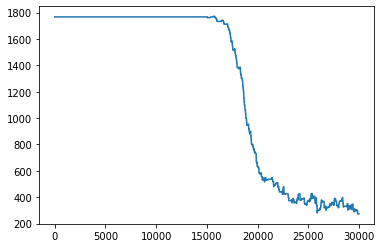

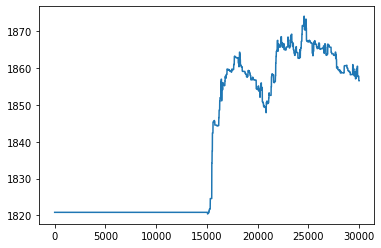

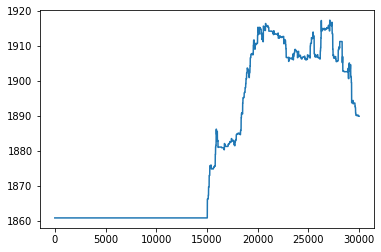

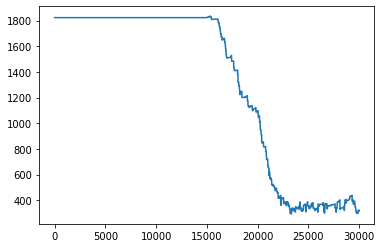

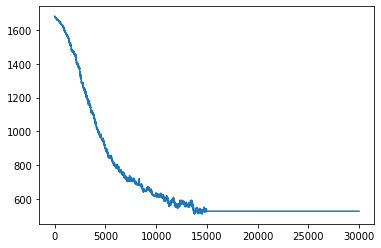

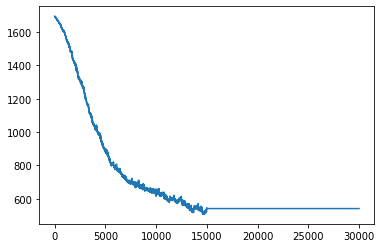

In [17]:
for name, m in zip(bl_monitors_name, bl_monitors):
    print(name)
    plt.figure()
    plt.plot(m.get('converge'))

In [18]:
# plt.plot(inp_2_c1_monitor_1.get('converge'))
# plt.figure()
# plt.plot(inp_2_c1_monitor_2.get('converge'))

In [19]:
time_show = time

In [20]:
spikes = {
    "L4 | 1": c1.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L4 | 2": c1.l4.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "L23 | 1": c1.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L23 | 2": c1.l23.monitors[1][1].get('s')[-time_show:,0,:].T,
}

## Confusion

### Layer 4

In [21]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -600:][:, timestep_class[-600:]].sum() / session_class[-20:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -600:][:, ~ timestep_class[-600:]].sum() / (~ session_class)[-20:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -600:][:, timestep_class[-600:]].sum() / session_class[-20:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -600:][:, ~ timestep_class[-600:]].sum() / (~ session_class)[-20:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    45.57143020629883
L4 -- Excitatory 1 -- Pattern 2     :    0.7692307829856873
L4 -- Excitatory 2 -- Pattern 1     :    0.4285714328289032
L4 -- Excitatory 2 -- Pattern 2     :    45.846153259277344


In [22]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    45.904762268066406
L4 -- Excitatory 1 -- Pattern 2     :    0.6551724076271057
L4 -- Excitatory 2 -- Pattern 1     :    0.6190476417541504
L4 -- Excitatory 2 -- Pattern 2     :    46.10344696044922


In [23]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    44.96154022216797
L4 -- Excitatory 1 -- Pattern 2     :    0.7291666865348816
L4 -- Excitatory 2 -- Pattern 1     :    0.6153846383094788
L4 -- Excitatory 2 -- Pattern 2     :    46.0625


In [24]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    45.386138916015625
L4 -- Excitatory 1 -- Pattern 2     :    13.975757598876953
L4 -- Excitatory 2 -- Pattern 1     :    13.221781730651855
L4 -- Excitatory 2 -- Pattern 2     :    45.79191970825195


### Layer 2,3

In [25]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    107.66666412353516
L4 -- Excitatory 1 -- Pattern 2     :    8.965517044067383
L4 -- Excitatory 2 -- Pattern 1     :    3.6666667461395264
L4 -- Excitatory 2 -- Pattern 2     :    114.13793182373047


In [26]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    118.30769348144531
L23 -- Excitatory 1 -- Pattern 2     :    9.854166984558105
L23 -- Excitatory 2 -- Pattern 1     :    2.269230842590332
L23 -- Excitatory 2 -- Pattern 2     :    101.04166412353516


In [27]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    45.613861083984375
L23 -- Excitatory 1 -- Pattern 2     :    6.244444370269775
L23 -- Excitatory 2 -- Pattern 1     :    51.45742416381836
L23 -- Excitatory 2 -- Pattern 2     :    98.89898681640625


## Pattern Separation

In [28]:
for source, target, connection in input_to_c1_connection.connections:
    print(f"{source} (0:99)    --->   {target}   :   {connection.w[:100, :].sum()}")
    print(f"{source} (100:199) --->   {target}   :   {connection.w[100:, :].sum()}")

input_c1 (0:99)    --->   c1_l4__exc1   :   402.0909423828125
input_c1 (100:199) --->   c1_l4__exc1   :   0.0
input_c1 (0:99)    --->   c1_l4__exc2   :   409.9647216796875
input_c1 (100:199) --->   c1_l4__exc2   :   0.0


In [29]:

for source, target, connection in c1.l4_l23.connections:
    print(f"{source}   --->   {target}   :   {connection.w.sum()}")

c1_l4__exc1   --->   c1_l23__exc1   :   3670.277099609375
c1_l4__exc1   --->   c1_l23__exc2   :   1842.31591796875
c1_l4__exc2   --->   c1_l23__exc1   :   1939.307373046875
c1_l4__exc2   --->   c1_l23__exc2   :   3944.041015625


## Activities

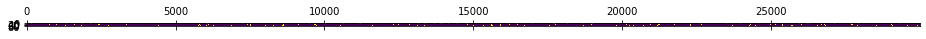

In [30]:
plt.matshow(spike_train.T[:, -time_show:])

In [31]:
c1.l4.monitors[0][1].get('s').shape

torch.Size([30000, 1, 50])

In [32]:
spikes["L4 | 1"].shape

torch.Size([50, 30000])

In [33]:
spikes["L4 | 1"].sum(0).shape[0]

30000

In [34]:
spikes["L4 | 1"][:,-150:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [35]:
spikes["L4 | 1"][:,-300:-270].sum()

tensor(4)

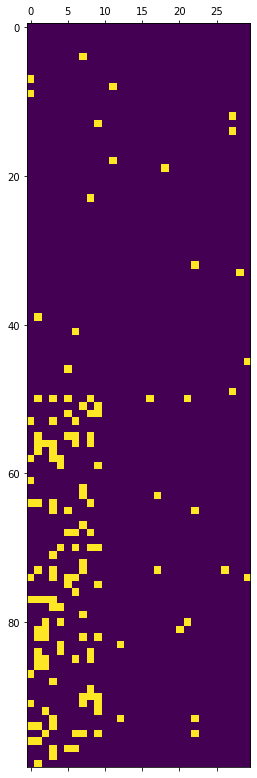

In [36]:
x = 396
plt.matshow(spike_train.T[:, x * each_session:x * each_session + each_session])

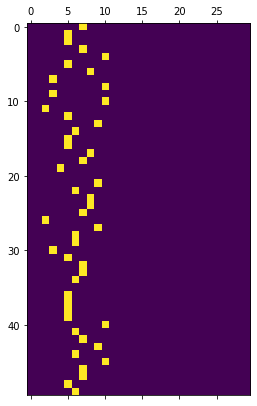

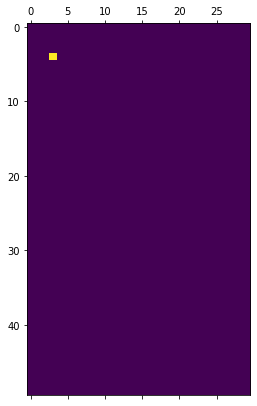

In [37]:
x = 398
plt.matshow(spikes["L4 | 1"][:, x * each_session:x * each_session + each_session])
plt.matshow(spikes["L4 | 2"][:, x * each_session:x * each_session + each_session])

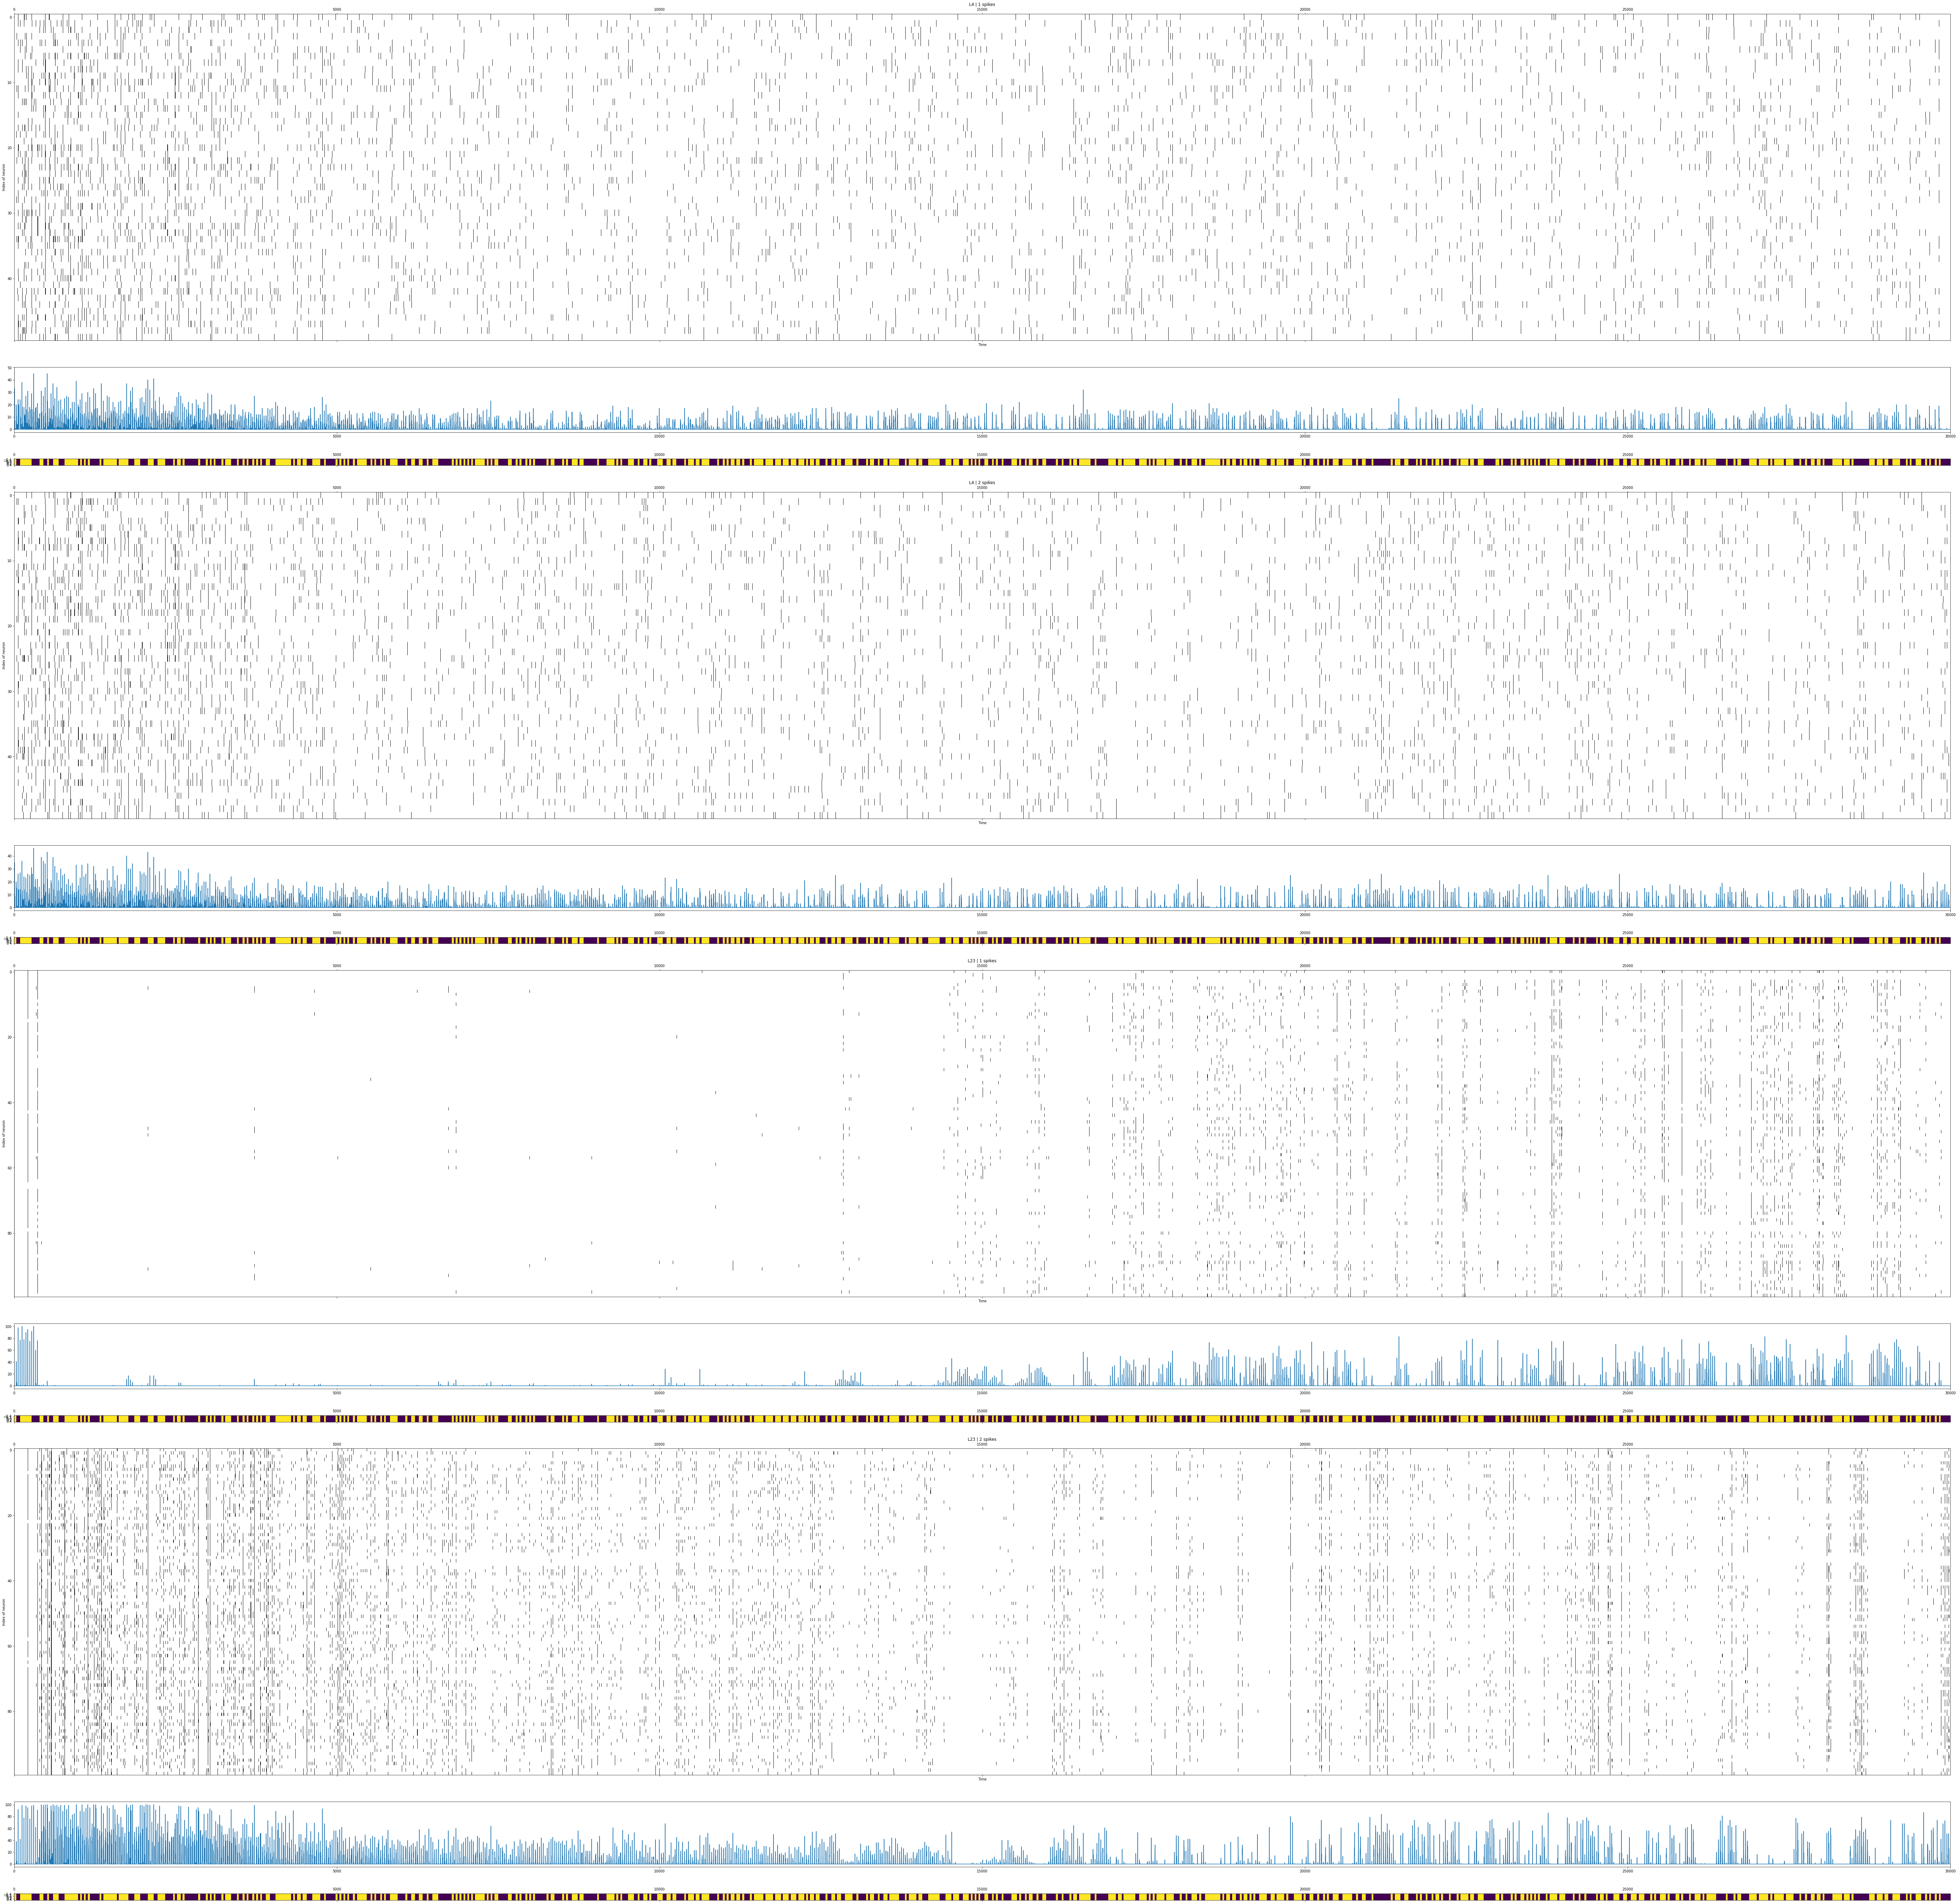

In [38]:
ver_num = len(spikes)
fig, axes = plt.subplots(ver_num * 3, 1, figsize=(100, 100), gridspec_kw={'height_ratios': [50, 10, 1] * ver_num})
# fig.suptitle(f"Spikes: t={start_time}-{end_time}")
for idx, layer in enumerate(spikes):
    indx = idx * 3
    axes[indx].matshow(spikes[layer], cmap='Greys')
    axes[indx].set_title('%s spikes' % layer)
    axes[indx].set_xlabel('Time')
    axes[indx].set_ylabel('Index of neuron')
    axes[indx].set_aspect('auto')
    
    activity = spikes[layer].sum(0)
    axes[indx + 1].plot(activity)
    axes[indx + 1].set_aspect('auto')
    axes[indx + 1].set_xlim([0, activity.shape[0]])
    
    axes[indx + 2].matshow(timestep_class[-time_show:].unsqueeze(1).T)
    axes[indx + 2].set_aspect('auto')

tensor(True)


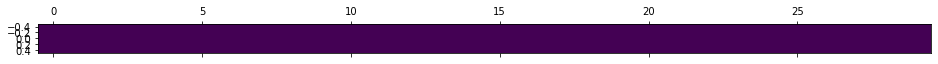

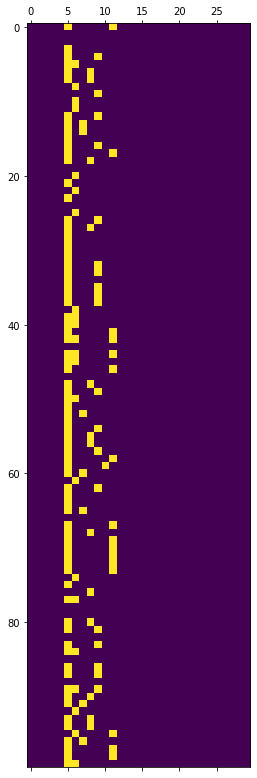

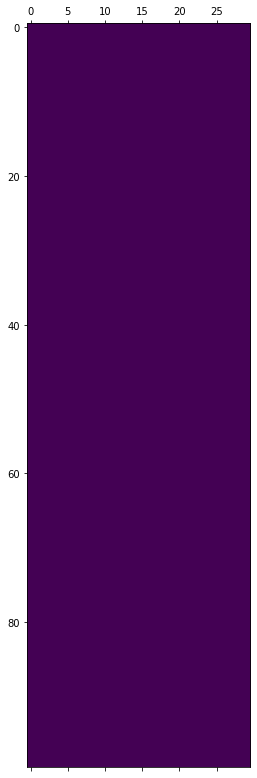

In [39]:
x = 794
print(session_class[x])
plt.matshow(timestep_class[x * each_session:x * each_session + each_session].unsqueeze(1).T)
plt.matshow(spikes["L23 | 1"][:, x * each_session:x * each_session + each_session])
plt.matshow(spikes["L23 | 2"][:, x * each_session:x * each_session + each_session])

# Save Model And Notebook

In [40]:
%%javascript
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});

<IPython.core.display.Javascript object>

In [44]:
model_name = 'c2'
c1_with_input.save(f'models/{model_name}.pt')
!! jupyter-nbconvert --to html .\c2-create.ipynb --stdout > models/{model_name}.html

['[NbConvertApp] Converting notebook .\\c2-create.ipynb to html']